# Rubrix Metrics

You can reproduce the results of our [blog post](https://www.rubrix.ml/blog/metrics/) with this notebook.

First, let's install all the necessary stuff:

In [ ]:
%pip install "rubrix[server]" "spacy<3.2.0"

In [ ]:
!pip install "https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl"

In [ ]:
!pip install "https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl"

## Define helper functions

In [ ]:
# retrieve annotation spans from an ann file, needs a doc to make sure spans align with the tokens
def get_annotation_spans(doc, ann_path: str):
    with open(ann_path) as f:
        annotations = f.readlines()

    spans = []

    for ann in annotations:
        annsplit = ann.split("\t")
        if annsplit[0].startswith("R") or annsplit[0].startswith("#"):
            continue 
                
        entity = annsplit[1].split()
        label = entity[0]
        # skip labels not supported by model
        if label.lower() == "reason" or label.lower() == "ade":
            continue
        start_idx = int(entity[1])
        end_idx = [int(idx) for idx in entity[2:] if ";" not in idx][-1]

        try:
            span = doc.char_span(
                start_idx, 
                end_idx, 
                label=label, 
                alignment_mode="expand"
            )
        except Exception as error:
            print(entity)
            raise error

        spans.append(span)
        
    return spans

In [ ]:
# create records for each sentence
import random
from pathlib import Path
from typing import List
import rubrix as rb

def create_records(text_path: str, ann_path: str, nlp: "spacy.lang", datashift: bool = False) -> List[rb.TokenClassificationRecord]:
    
    # read txt file
    with open(text_path) as f:
        text = f.read()
    
    if datashift:
        text = text.lower()
    
    # call spaCy pipeline
    doc = nlp(text)
    
    # get annotations
    annotation_spans = get_annotation_spans(doc, ann_path)
    
    records = []
    for i, sent in enumerate(list(doc.sents)):
        if not sent.text.strip():
            continue 
        annotation = []
        for span in annotation_spans:
            # keep only spans that do not cross sentence boundaries
            if span.start_char < sent.start_char or span.end_char > sent.end_char:
                continue
            # we must correct the char indexes for the sentence start char index
            if span.sent == sent:
                annotation.append(
                    (span.label_.title(), span.start_char - sent.start_char, span.end_char - sent.start_char)
                )

        # we must correct the char indexes for the sentence start char index
        prediction = [
            (ent.label_.title(), ent.start_char - sent.start_char, ent.end_char - sent.start_char) 
            for ent in sent.ents
        ] or None

        records.append(
            rb.TokenClassificationRecord(
                text=sent.text,
                tokens=list(map(str, sent)),
                prediction=prediction,
                prediction_agent=nlp.meta["name"],
                annotation=annotation,
                id=f"{Path(text_path).name}_{i}",
            )
        )  

    return records

## Upload records to Rubrix

### Get file paths

In [ ]:
# get file paths
import os

# path to folder with all n2c2 *.txt and *.ann files
folderpath = "./n2c2_files/files"

# for the blog post we only used following 12 files
files = ['139955.txt', '104168.txt', '104140.txt', '155521.txt', '100130.txt', '112520.txt', '107515.txt', '109698.txt', '110135.txt', '116237.txt', '152925.txt', '146944.txt']

# get file paths
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath) if name in files]
filepaths;

### Create records

In [ ]:
import spacy
from tqdm.auto import tqdm

def return_records(filepaths: List[str], spacy_model_name: str, datashift: bool = False):
    nlp = spacy.load(spacy_model_name)
    
    # add sentencizer to be able to divide docs into sentences
    nlp.add_pipe('sentencizer')

    records = []
    for i, file in tqdm(enumerate(filepaths), total=len(filepaths)):
        annfile = file.replace(".txt", ".ann")
        is_datashift = False
        if datashift and i%4 == 0:
            is_datashift = True
        records += create_records(file, annfile, nlp, is_datashift)

    return records

#### transformer model

In [ ]:
records_trf = return_records(filepaths, "en_core_med7_trf")

In [ ]:
# log to rubrix
rb.log(records_trf, "med7_trf")

#### large model

In [ ]:
records_lg = return_records(filepaths, "en_core_med7_lg")

In [ ]:
# log to rubrix
rb.log(records_lg, "med7_lg")

#### data shift

In [ ]:
# simulate data-shift

records_datashift = return_records(filepaths, "en_core_med7_trf", True)

In [ ]:
# log to rubrix
rb.log(records_datashift, "med7_trf_datashift")

## METRICS

### Token capitalness

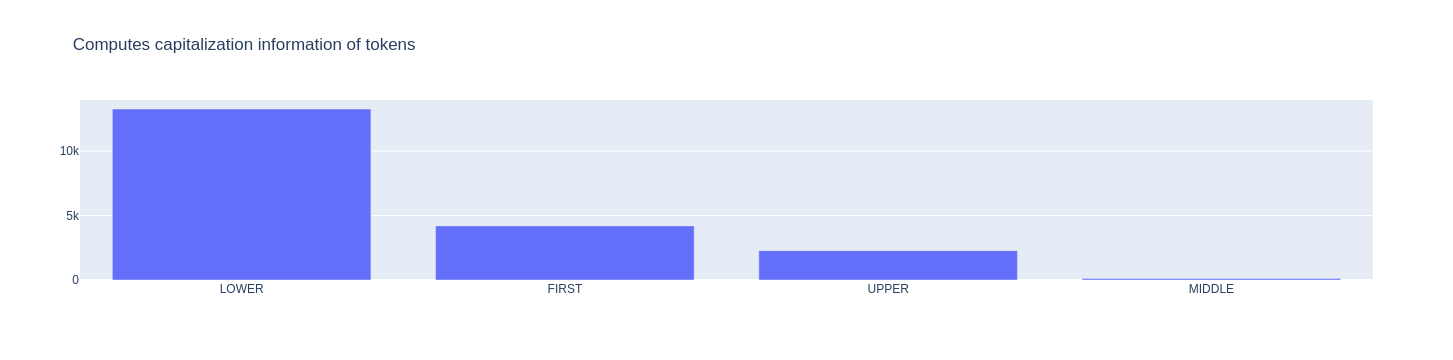

In [45]:
from rubrix.metrics.token_classification import token_capitalness

token_capitalness(name="med7_trf").visualize()

### Token frequency

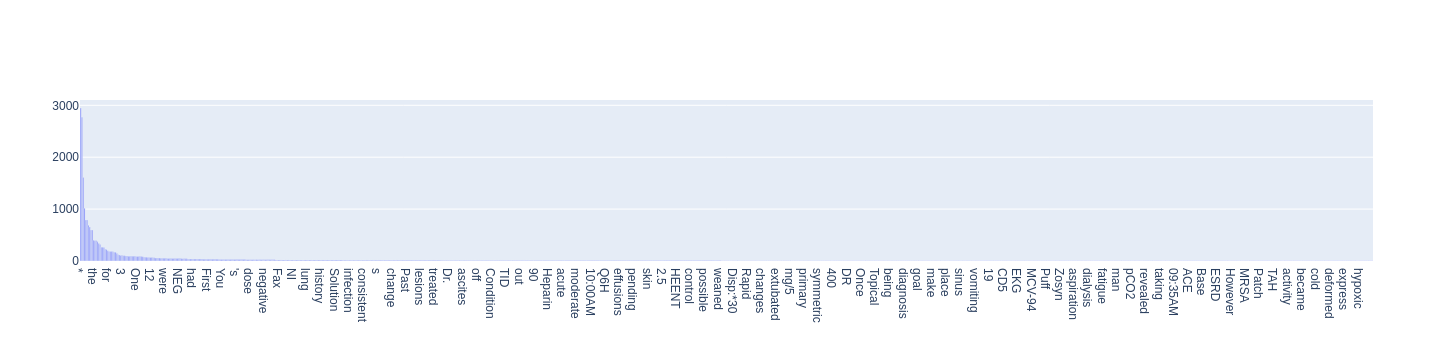

In [28]:
from rubrix.metrics.token_classification import token_frequency

token_frequency(name="med7_trf").visualize()

### Token length

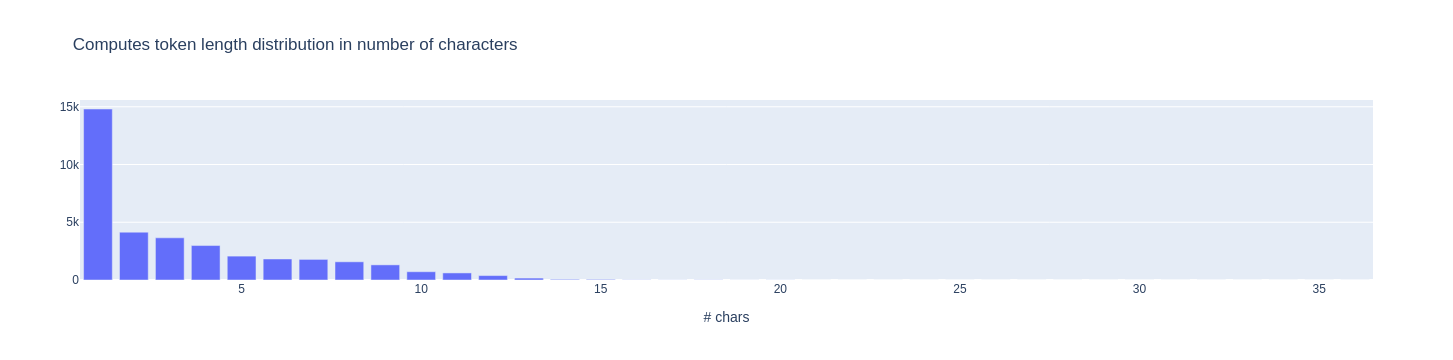

In [29]:
from rubrix.metrics.token_classification import token_length

token_length(name="med7_trf").visualize()

### Entity capitalness

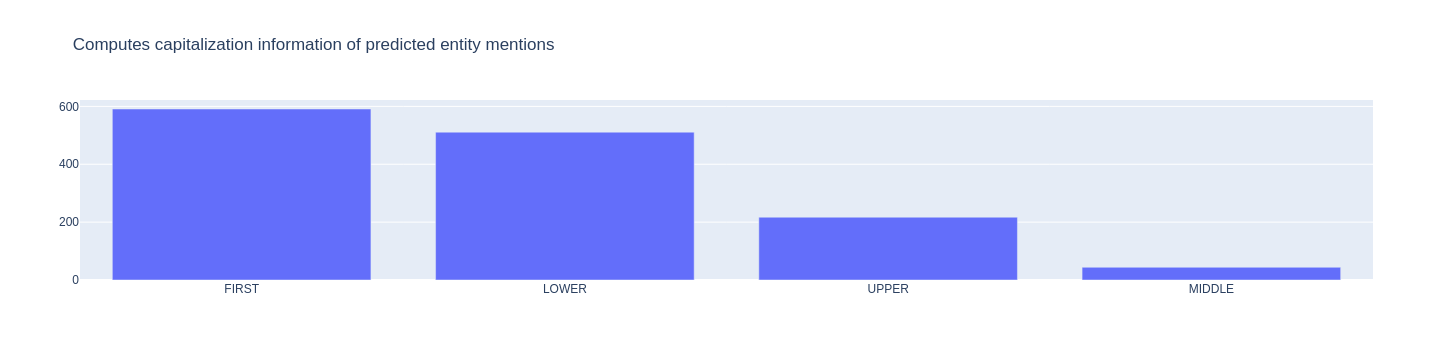

In [36]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="med7_trf").visualize()

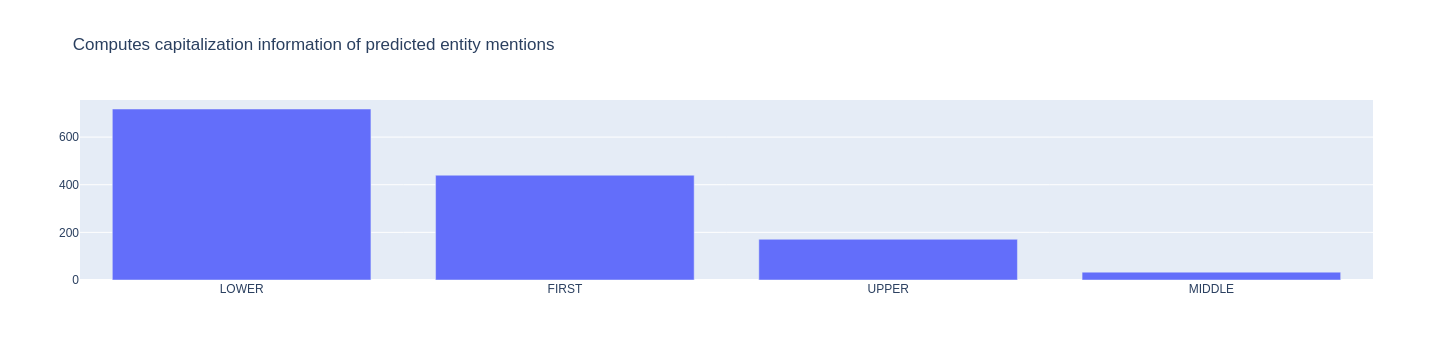

In [37]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="med7_trf_datashift").visualize()

### Entity consistency

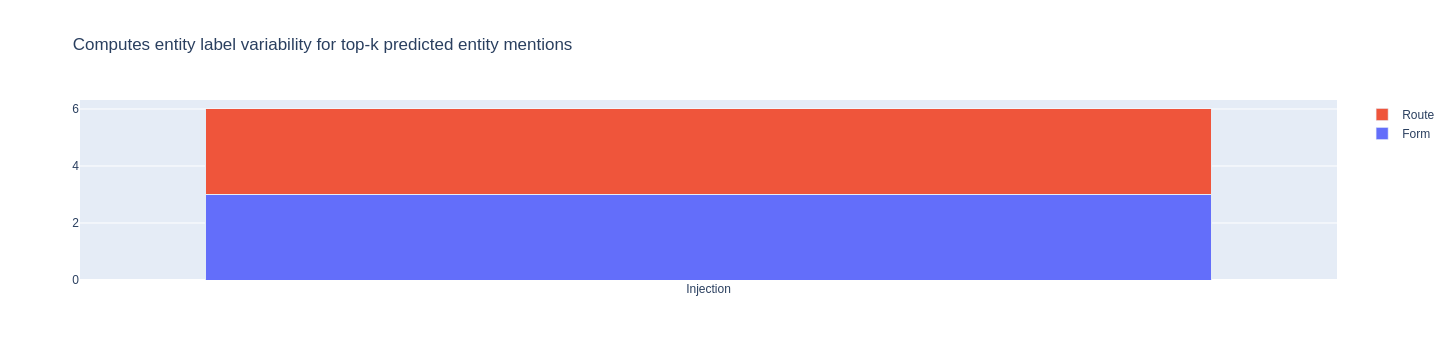

In [33]:
from rubrix.metrics.token_classification import entity_consistency

entity_consistency(name="med7_trf", mentions=10000, threshold=1).visualize()

### Entity labels

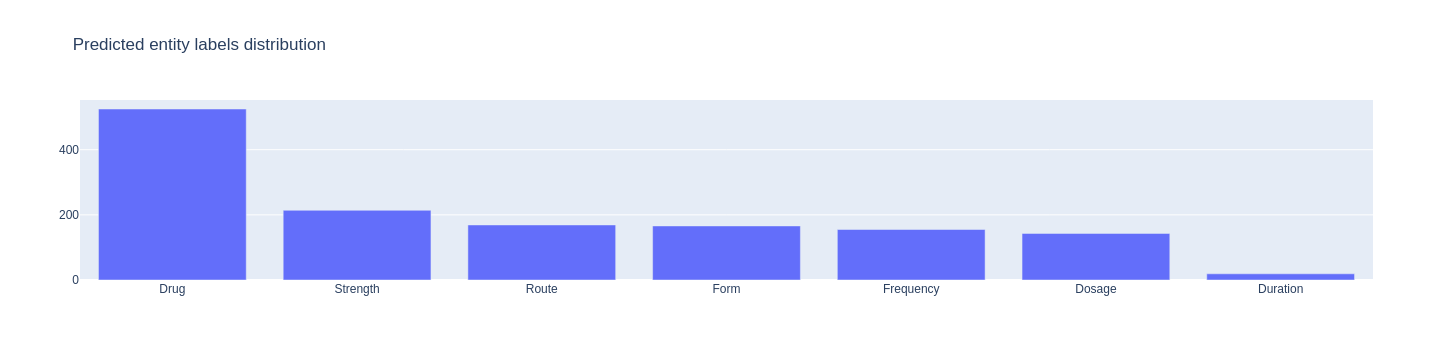

In [38]:
from rubrix.metrics.token_classification import entity_labels

entity_labels(name="med7_trf").visualize()

### Mention length

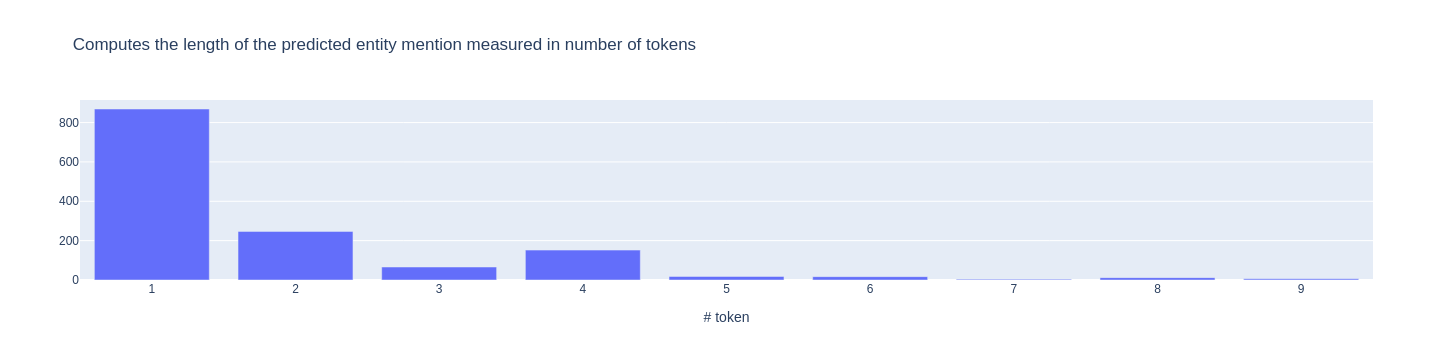

In [40]:
from rubrix.metrics.token_classification import mention_length

mention_length(name="med7_trf").visualize()

### F1 Score

In [42]:
from rubrix.metrics.token_classification import f1

f1(name="med7_trf").data

{'precision_macro': 0.9411107279238622,
 'recall_macro': 0.8632071841891655,
 'f1_macro': 0.9004771675851806,
 'precision_micro': 0.9377551020408164,
 'recall_micro': 0.8760724499523356,
 'f1_micro': 0.905864958107442,
 'Drug_precision': 0.9387186629526463,
 'Drug_recall': 0.9601139601139601,
 'Drug_f1': 0.9492957746478873,
 'Dosage_precision': 0.9473684210526315,
 'Dosage_recall': 0.8674698795180723,
 'Dosage_f1': 0.9056603773584905,
 'Route_precision': 0.9391304347826087,
 'Route_recall': 0.9152542372881356,
 'Route_f1': 0.9270386266094419,
 'Duration_precision': 0.9473684210526315,
 'Duration_recall': 0.782608695652174,
 'Duration_f1': 0.8571428571428571,
 'Form_precision': 0.9829059829059829,
 'Form_recall': 0.8984375,
 'Form_f1': 0.9387755102040816,
 'Frequency_precision': 0.881578947368421,
 'Frequency_recall': 0.6473429951690821,
 'Frequency_f1': 0.7465181058495821,
 'Strength_precision': 0.9507042253521126,
 'Strength_recall': 0.9712230215827338,
 'Strength_f1': 0.9608540925266

In [43]:
from rubrix.metrics.token_classification import f1

f1(name="med7_lg").data

{'precision_macro': 0.9020948781553928,
 'recall_macro': 0.8303217594903378,
 'f1_macro': 0.8647215573675181,
 'precision_micro': 0.9126506024096386,
 'recall_micro': 0.8665395614871306,
 'f1_micro': 0.8889975550122249,
 'Drug_precision': 0.9152542372881356,
 'Drug_recall': 0.9230769230769231,
 'Drug_f1': 0.9191489361702128,
 'Dosage_precision': 0.8641975308641975,
 'Dosage_recall': 0.8433734939759037,
 'Dosage_f1': 0.8536585365853657,
 'Route_precision': 0.9426229508196722,
 'Route_recall': 0.9745762711864406,
 'Route_f1': 0.9583333333333334,
 'Duration_precision': 0.8125,
 'Duration_recall': 0.5652173913043478,
 'Duration_f1': 0.6666666666666667,
 'Form_precision': 0.9824561403508771,
 'Form_recall': 0.875,
 'Form_f1': 0.9256198347107438,
 'Frequency_precision': 0.8352272727272727,
 'Frequency_recall': 0.7101449275362319,
 'Frequency_f1': 0.7676240208877285,
 'Strength_precision': 0.9624060150375939,
 'Strength_recall': 0.920863309352518,
 'Strength_f1': 0.9411764705882353}

In [44]:
from rubrix.metrics.token_classification import f1

f1(name="med7_trf_datashift").data

{'precision_macro': 0.938662355372563,
 'recall_macro': 0.8623165041219578,
 'f1_macro': 0.8988712294634393,
 'precision_micro': 0.9348931841302136,
 'recall_micro': 0.8752380952380953,
 'f1_micro': 0.9040826364977864,
 'Drug_precision': 0.9361111111111111,
 'Drug_recall': 0.9601139601139601,
 'Drug_f1': 0.9479606188466948,
 'Dosage_precision': 0.948051948051948,
 'Dosage_recall': 0.8690476190476191,
 'Dosage_f1': 0.906832298136646,
 'Route_precision': 0.9473684210526315,
 'Route_recall': 0.9152542372881356,
 'Route_f1': 0.9310344827586206,
 'Duration_precision': 0.9473684210526315,
 'Duration_recall': 0.782608695652174,
 'Duration_f1': 0.8571428571428571,
 'Form_precision': 0.9661016949152542,
 'Form_recall': 0.890625,
 'Form_f1': 0.9268292682926829,
 'Frequency_precision': 0.881578947368421,
 'Frequency_recall': 0.6473429951690821,
 'Frequency_f1': 0.7465181058495821,
 'Strength_precision': 0.9440559440559441,
 'Strength_recall': 0.9712230215827338,
 'Strength_f1': 0.9574468085106383